In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import time
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import cv2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


IMAGE_SIZE = 224
BATCH_SIZE = 8
LR         = 1e-4
EPOCHS     = 20
VAL_SIZE   = 0.2


RUN_LOG = "run_log_emotrigger_v2.csv"


CSV_PATH   = "/content/Last_Updated_emotion_csv.xlsx - new (1).csv"
VIDEO_ROOT = "/content/drive/MyDrive/EmotionProject/clips"


VIDEO_ID_COL = "ID"


Using device: cpu


In [ ]:
df = pd.read_csv(CSV_PATH)
print("Original rows:", len(df))
print("Columns:", df.columns.tolist())
print(df.head())


emo_le = LabelEncoder()
trg_le = LabelEncoder()

df["emo_idx"] = emo_le.fit_transform(df["Emotion"])
df["trg_idx"] = trg_le.fit_transform(df["Trigger"])

num_emo_classes = len(emo_le.classes_)
num_trg_classes = len(trg_le.classes_)

print("Emotion classes:", list(emo_le.classes_))
print("Trigger classes:", list(trg_le.classes_))
print("num_emo_classes:", num_emo_classes, "num_trg_classes:", num_trg_classes)


Original rows: 87
Columns: ['ID', 'Text', 'Emotion', 'Trigger', 'audio(needs adjustments..easy to do by code)', 'LLM-Confidence_trigger label']
         ID                                               Text Emotion  \
0  H_YT_001         And I can't get rid of this picture either     Sad   
1  H_YT_002  Why are you so sick in the head? Why can't you...   Angry   
2  H_YT_003  I wish I could see her at her first day at school     Sad   
3  H_YT_005  How no matter how much I'd like to not hate yo...   Angry   
4  H_YT_006                                      I'll miss you     Sad   

                 Trigger audio(needs adjustments..easy to do by code)  \
0    Worry for loved one                                          NaN   
1  Relationship conflict                                          NaN   
2    Worry for loved one                                          NaN   
3  Relationship conflict                                          NaN   
4    Worry for loved one                      

In [ ]:
def attach_video_paths(df, video_root, video_id_col):

    if df is None:
        raise ValueError("df is None - reload CSV first")
    if video_id_col not in df.columns:
        raise KeyError(f"Column '{video_id_col}' not in df.columns = {df.columns.tolist()}")

    all_files = [
        f for f in os.listdir(video_root)
        if f.lower().endswith((".mp4", ".mkv", ".avi", ".mov"))
    ]
    stems = [os.path.splitext(f)[0] for f in all_files]
    stem_to_file = {stem: fname for stem, fname in zip(stems, all_files)}

    paths = []
    missing_ids = []
    ambiguous = []

    for vid in df[video_id_col]:
        vid = str(vid).strip()
        fname = None

        candidates = []

        for stem in stems:
            if stem == vid:
                candidates.append(stem)
            elif vid.endswith("_new") and stem == vid[:-4]:
                candidates.append(stem)
            elif stem == vid + "_new":
                candidates.append(stem)
            elif stem == "Copy of " + vid:
                candidates.append(stem)
            elif vid in stem or stem in vid:
                candidates.append(stem)

        candidates = list(set(candidates))

        if len(candidates) == 0:
            missing_ids.append(vid)
            paths.append(None)
        else:
            if len(candidates) > 1:
                ambiguous.append((vid, candidates))
            chosen_stem = candidates[0]
            fname = stem_to_file[chosen_stem]
            paths.append(os.path.join(video_root, fname))

    df = df.copy()
    df["video_path"] = paths

    found = df["video_path"].notna().sum()
    #print(f"Resolved paths for {found} / {len(df)} rows.")
    if missing_ids:
        print("Unresolved IDs (first few):", missing_ids[:10])
    if ambiguous:
        print("Ambiguous IDs (first few):")
        for vid, cands in ambiguous[:5]:
            print(f"  {vid} -> {cands}")

    df = df[df["video_path"].notna()].reset_index(drop=True)
    return df

df = attach_video_paths(df, VIDEO_ROOT, VIDEO_ID_COL)
print("Usable rows after matching:", len(df))
print(df[[VIDEO_ID_COL, "video_path"]].head())


Unresolved IDs (first few): ['Video1_Clip', 'Video2_Clip', 'Video3_Clip', 'Video4_Clip', 'Video5_Clip', 'Video6_Clip', 'Video7_Clip', 'Video8_Clip', 'Video9_Clip', 'Video10_Clip']
Ambiguous IDs (first few):
  YT_2fcd227f_new -> ['YT_2fcd227f', 'YT_2fcd227f_new_processed_224x224']
  YT_0fb0b651_new -> ['YT_0fb0b651', 'YT_0fb0b651_new_processed_224x224']
  YT_1cd3ec7a_new -> ['YT_1cd3ec7a', 'YT_1cd3ec7a_new_processed_224x224']
  YT_01c4ba33_new -> ['YT_01c4ba33', 'YT_01c4ba33_new_processed_224x224']
  YT_1cc50f02_new -> ['YT_1cc50f02_new_processed_224x224', 'YT_1cc50f02']
Usable rows after matching: 75
         ID                                         video_path
0  H_YT_001  /content/drive/MyDrive/EmotionProject/clips/Co...
1  H_YT_002  /content/drive/MyDrive/EmotionProject/clips/Co...
2  H_YT_003  /content/drive/MyDrive/EmotionProject/clips/Co...
3  H_YT_005  /content/drive/MyDrive/EmotionProject/clips/Co...
4  H_YT_006  /content/drive/MyDrive/EmotionProject/clips/Co...


In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

def load_frame_from_video(video_path, frame_idx=None):

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(f"Cannot open video: {video_path}")

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames == 0:
        cap.release()
        raise ValueError(f"No frames in video: {video_path}")

    if frame_idx is None:
        frame_idx = total_frames // 2

    frame_idx = max(0, min(frame_idx, total_frames - 1))
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ok, frame = cap.read()
    cap.release()

    if not ok or frame is None:
        raise RuntimeError(f"Failed to read frame {frame_idx} from {video_path}")

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(frame)
    return img, total_frames


In [ ]:
class EmotionTriggerVideoDataset(Dataset):

    def __init__(self, df, transform=None, random_frame=False):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.random_frame = random_frame

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        video_path = row["video_path"]


        if ("frame_idx" in row) and (not self.random_frame):
            frame_idx = int(row["frame_idx"])
        else:
            frame_idx = None

        img, total_frames = load_frame_from_video(video_path, frame_idx)

        if self.random_frame:
            rand_idx = np.random.randint(0, total_frames)
            img, _ = load_frame_from_video(video_path, rand_idx)

        if self.transform:
            img = self.transform(img)

        emo_label = int(row["emo_idx"])
        trg_label = int(row["trg_idx"])
        return img, emo_label, trg_label


def expand_uniform_k_frames(df, k_frames=8):

    records = []
    for _, row in df.iterrows():
        video_path = row["video_path"]
        try:

            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                continue
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            cap.release()
            if total_frames <= 0:
                continue

            indices = np.linspace(0, total_frames - 1, k_frames, dtype=int)
            for fi in indices:
                rec = row.copy()
                rec["frame_idx"] = int(fi)
                records.append(rec)
        except Exception as e:
            print("Error for video:", video_path, "->", e)

    df_k = pd.DataFrame(records).reset_index(drop=True)
    print(f"Expanded to {len(df_k)} frame-level samples from {len(df)} videos (k={k_frames})")
    return df_k


In [ ]:
def accuracy_from_logits(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

def train_one_epoch(model, loader, optimizer, device, ce_emo, ce_trg):
    model.train()
    running_loss = 0.0
    running_emo_acc = 0.0
    running_trg_acc = 0.0
    total = 0

    for images, emo_labels, trg_labels in loader:
        images = images.to(device)
        emo_labels = emo_labels.to(device)
        trg_labels = trg_labels.to(device)

        optimizer.zero_grad()
        emo_logits, trg_logits = model(images)

        loss_emo = ce_emo(emo_logits, emo_labels)
        loss_trg = ce_trg(trg_logits, trg_labels)
        loss = (loss_emo + loss_trg) / 2.0

        loss.backward()
        optimizer.step()

        bs = images.size(0)
        running_loss += loss.item() * bs
        running_emo_acc += accuracy_from_logits(emo_logits, emo_labels) * bs
        running_trg_acc += accuracy_from_logits(trg_logits, trg_labels) * bs
        total += bs

    return (
        running_loss / total,
        running_emo_acc / total,
        running_trg_acc / total,
    )


def evaluate(model, loader, device, ce_emo, ce_trg):
    model.eval()
    running_loss = 0.0
    running_emo_acc = 0.0
    running_trg_acc = 0.0
    total = 0

    with torch.no_grad():
        for images, emo_labels, trg_labels in loader:
            images = images.to(device)
            emo_labels = emo_labels.to(device)
            trg_labels = trg_labels.to(device)

            emo_logits, trg_logits = model(images)

            loss_emo = ce_emo(emo_logits, emo_labels)
            loss_trg = ce_trg(trg_logits, trg_labels)
            loss = (loss_emo + loss_trg) / 2.0

            bs = images.size(0)
            running_loss += loss.item() * bs
            running_emo_acc += accuracy_from_logits(emo_logits, emo_labels) * bs
            running_trg_acc += accuracy_from_logits(trg_logits, trg_labels) * bs
            total += bs

    return (
        running_loss / total,
        running_emo_acc / total,
        running_trg_acc / total,
    )


def train_model(model, train_loader, val_loader, device, epochs,
                run_name="run", strategy="middle", model_name="SimpleCNN"):
    ce_emo = nn.CrossEntropyLoss()
    ce_trg = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_emo_acc": [],
        "val_emo_acc": [],
        "train_trg_acc": [],
        "val_trg_acc": [],
    }

    best_val_loss = float("inf")
    best_state = None

    for ep in range(1, epochs + 1):
        t0 = time.time()
        tr_loss, tr_emo_acc, tr_trg_acc = train_one_epoch(model, train_loader, optimizer, device, ce_emo, ce_trg)
        val_loss, val_emo_acc, val_trg_acc = evaluate(model, val_loader, device, ce_emo, ce_trg)
        dt = time.time() - t0

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(val_loss)
        history["train_emo_acc"].append(tr_emo_acc)
        history["val_emo_acc"].append(val_emo_acc)
        history["train_trg_acc"].append(tr_trg_acc)
        history["val_trg_acc"].append(val_trg_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()

        print(
            f"Epoch {ep:02d}/{epochs} | "
            f"train_loss={tr_loss:.4f} val_loss={val_loss:.4f} | "
            f"emo_acc: {tr_emo_acc:.3f}/{val_emo_acc:.3f} | "
            f"trg_acc: {tr_trg_acc:.3f}/{val_trg_acc:.3f} | "
            f"time={dt:.1f}s"
        )

    if best_state is not None:
        model_path = f"{run_name}_best.pt"
        torch.save(best_state, model_path)
        print(f"Best model saved to {model_path} (val_loss={best_val_loss:.4f})")

    log_run(history, run_name, strategy=strategy, model_name=model_name)
    return history


def log_run(history, run_name, strategy="middle", model_name="SimpleCNN"):
    last = len(history["train_loss"]) - 1

    record = {
        "run_name": run_name,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "model_name": model_name,
        "strategy": strategy,
        "epochs": len(history["train_loss"]),
        "final_train_loss": history["train_loss"][last],
        "final_val_loss": history["val_loss"][last],
        "final_train_emo_acc": history["train_emo_acc"][last],
        "final_val_emo_acc": history["val_emo_acc"][last],
        "final_train_trg_acc": history["train_trg_acc"][last],
        "final_val_trg_acc": history["val_trg_acc"][last],
        "best_val_loss": min(history["val_loss"]),
        "best_val_emo_acc": max(history["val_emo_acc"]),
        "best_val_trg_acc": max(history["val_trg_acc"]),
    }

    if os.path.exists(RUN_LOG):
        log_df = pd.read_csv(RUN_LOG)
        log_df = pd.concat([log_df, pd.DataFrame([record])], ignore_index=True)
    else:
        log_df = pd.DataFrame([record])

    log_df.to_csv(RUN_LOG, index=False)
    print(f"Run logged to {RUN_LOG}")


In [ ]:
def plot_history(history, title_suffix=""):
    epochs = range(1, len(history["train_loss"]) + 1)


    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss Curves {title_suffix}")
    plt.legend()
    plt.grid(True)
    plt.show()


    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history["train_emo_acc"], label="Train Emo Acc")
    plt.plot(epochs, history["val_emo_acc"], label="Val Emo Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Emotion Accuracy Curves {title_suffix}")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history["train_trg_acc"], label="Train Trg Acc")
    plt.plot(epochs, history["val_trg_acc"], label="Val Trg Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Trigger Accuracy Curves {title_suffix}")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
K_FRAMES = 8

df_k = expand_uniform_k_frames(df, k_frames=K_FRAMES)
df_k.to_csv("/content/emotrigger_k8_frames.csv", index=False)


print(df_k.head())

train_df_k, val_df_k = train_test_split(
    df_k,
    test_size=VAL_SIZE,
    random_state=SEED,
    stratify=df_k["emo_idx"],
)

train_dataset_k = EmotionTriggerVideoDataset(train_df_k, transform=train_transform, random_frame=False)
val_dataset_k   = EmotionTriggerVideoDataset(val_df_k,   transform=val_transform,   random_frame=False)

train_loader_k = DataLoader(train_dataset_k, batch_size=BATCH_SIZE,
                            shuffle=True, num_workers=0, pin_memory=False)
val_loader_k   = DataLoader(val_dataset_k,   batch_size=BATCH_SIZE,
                            shuffle=False, num_workers=0, pin_memory=False)

print("Train samples (uniform K):", len(train_dataset_k))
print("Val samples (uniform K):", len(val_dataset_k))


Expanded to 592 frame-level samples from 75 videos (k=8)
         ID                                        Text Emotion  \
0  H_YT_001  And I can't get rid of this picture either     Sad   
1  H_YT_001  And I can't get rid of this picture either     Sad   
2  H_YT_001  And I can't get rid of this picture either     Sad   
3  H_YT_001  And I can't get rid of this picture either     Sad   
4  H_YT_001  And I can't get rid of this picture either     Sad   

               Trigger audio(needs adjustments..easy to do by code)  \
0  Worry for loved one                                          NaN   
1  Worry for loved one                                          NaN   
2  Worry for loved one                                          NaN   
3  Worry for loved one                                          NaN   
4  Worry for loved one                                          NaN   

   LLM-Confidence_trigger label  emo_idx  trg_idx  \
0                           NaN        2        6   
1      

In [ ]:
#here trying with padding 0
class EmotionTriggerSimpleCNN(nn.Module):
    def __init__(self, num_emo_classes, num_trg_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_shared = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
        )
        self.fc_emo = nn.Linear(256, num_emo_classes)
        self.fc_trg = nn.Linear(256, num_trg_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = self.fc_shared(x)
        emo_logits = self.fc_emo(x)
        trg_logits = self.fc_trg(x)
        return emo_logits, trg_logits

simple_cnn = EmotionTriggerSimpleCNN(num_emo_classes, num_trg_classes).to(DEVICE)
print(simple_cnn)


EmotionTriggerSimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReL

Epoch 01/20 | train_loss=1.5780 val_loss=1.4577 | emo_acc: 0.402/0.525 | trg_acc: 0.290/0.483 | time=203.7s
Epoch 02/20 | train_loss=1.4557 val_loss=1.3420 | emo_acc: 0.490/0.550 | trg_acc: 0.450/0.500 | time=191.5s
Epoch 03/20 | train_loss=1.3793 val_loss=1.2286 | emo_acc: 0.479/0.600 | trg_acc: 0.456/0.533 | time=184.6s
Epoch 04/20 | train_loss=1.3024 val_loss=1.1520 | emo_acc: 0.506/0.583 | trg_acc: 0.485/0.583 | time=187.0s
Epoch 05/20 | train_loss=1.2125 val_loss=1.0664 | emo_acc: 0.550/0.600 | trg_acc: 0.525/0.550 | time=185.6s
Epoch 06/20 | train_loss=1.2150 val_loss=1.0554 | emo_acc: 0.508/0.600 | trg_acc: 0.531/0.550 | time=186.9s
Epoch 07/20 | train_loss=1.1695 val_loss=1.0057 | emo_acc: 0.550/0.583 | trg_acc: 0.510/0.600 | time=207.4s
Epoch 08/20 | train_loss=1.1045 val_loss=0.9861 | emo_acc: 0.537/0.608 | trg_acc: 0.546/0.608 | time=184.7s
Epoch 09/20 | train_loss=1.0813 val_loss=0.9395 | emo_acc: 0.575/0.608 | trg_acc: 0.573/0.608 | time=189.1s
Epoch 10/20 | train_loss=1.0

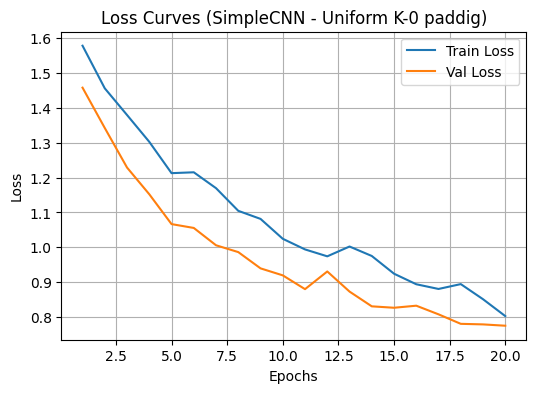

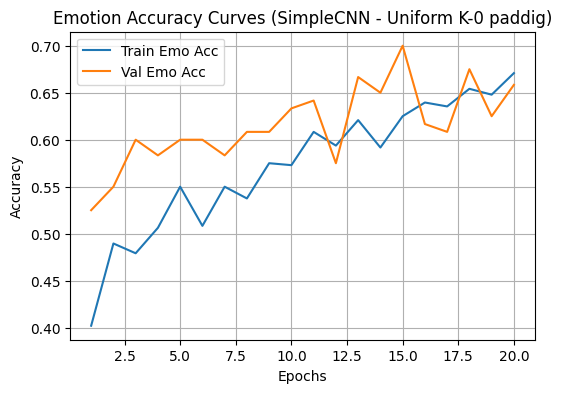

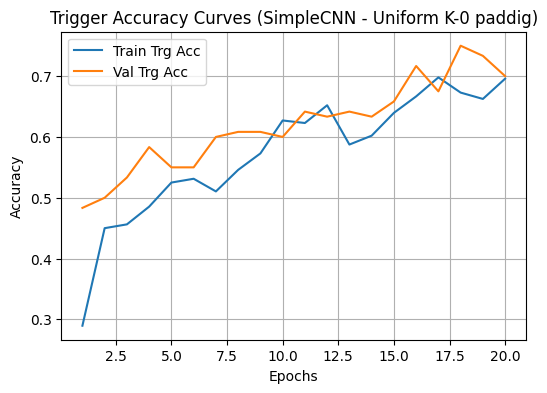

In [ ]:
run_name = "simplecnn_uniformK_0padding"
history_uniform = train_model(
    simple_cnn,
    train_loader_k,
    val_loader_k,
    DEVICE,
    EPOCHS,
    run_name=run_name,
    strategy=f"uniform_{K_FRAMES}",
    model_name="SimpleCNN",
)

plot_history(history_uniform, title_suffix="(SimpleCNN - Uniform K-0 paddig)")

In [ ]:
#adding padding =1
class EmotionTriggerSimpleCNN(nn.Module):
    def __init__(self, num_emo_classes, num_trg_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_shared = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
        )
        self.fc_emo = nn.Linear(256, num_emo_classes)
        self.fc_trg = nn.Linear(256, num_trg_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = self.fc_shared(x)
        emo_logits = self.fc_emo(x)
        trg_logits = self.fc_trg(x)
        return emo_logits, trg_logits

simple_cnn = EmotionTriggerSimpleCNN(num_emo_classes, num_trg_classes).to(DEVICE)
print(simple_cnn)


EmotionTriggerSimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, mo

Epoch 01/20 | train_loss=1.5557 val_loss=1.4297 | emo_acc: 0.369/0.492 | trg_acc: 0.281/0.350 | time=195.2s
Epoch 02/20 | train_loss=1.4167 val_loss=1.3055 | emo_acc: 0.465/0.550 | trg_acc: 0.425/0.475 | time=195.1s
Epoch 03/20 | train_loss=1.3652 val_loss=1.2315 | emo_acc: 0.473/0.533 | trg_acc: 0.454/0.500 | time=195.5s
Epoch 04/20 | train_loss=1.3018 val_loss=1.1495 | emo_acc: 0.498/0.550 | trg_acc: 0.487/0.600 | time=195.3s
Epoch 05/20 | train_loss=1.2578 val_loss=1.1083 | emo_acc: 0.519/0.600 | trg_acc: 0.487/0.592 | time=194.8s
Epoch 06/20 | train_loss=1.1974 val_loss=1.0238 | emo_acc: 0.556/0.617 | trg_acc: 0.512/0.575 | time=197.4s
Epoch 07/20 | train_loss=1.1495 val_loss=0.9992 | emo_acc: 0.527/0.592 | trg_acc: 0.540/0.617 | time=202.1s
Epoch 08/20 | train_loss=1.1120 val_loss=0.9769 | emo_acc: 0.504/0.625 | trg_acc: 0.565/0.575 | time=203.7s
Epoch 09/20 | train_loss=1.0770 val_loss=0.9653 | emo_acc: 0.552/0.542 | trg_acc: 0.556/0.600 | time=198.2s
Epoch 10/20 | train_loss=1.0

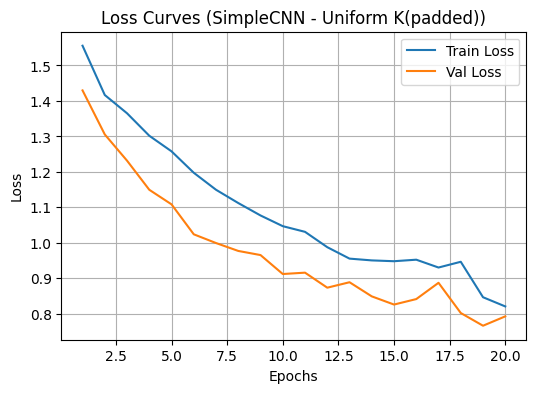

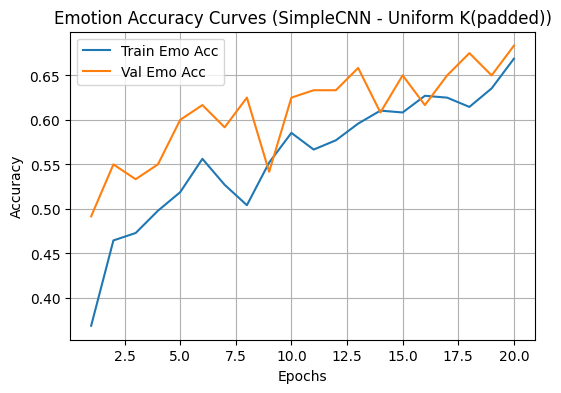

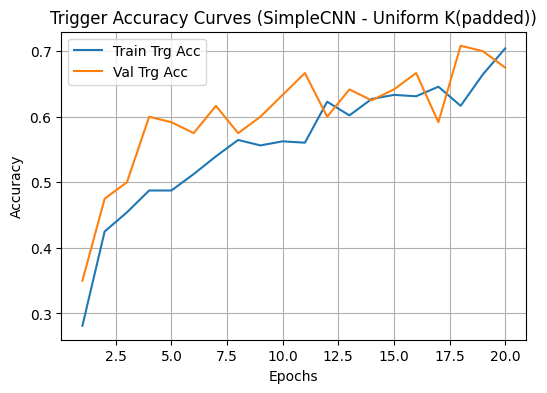

In [ ]:
run_name = "simplecnn_uniformK-withpadding"
history_uniform = train_model(
    simple_cnn,
    train_loader_k,
    val_loader_k,
    DEVICE,
    EPOCHS,
    run_name=run_name,
    strategy=f"uniform_{K_FRAMES}",
    model_name="SimpleCNN",
)

plot_history(history_uniform, title_suffix="(SimpleCNN - Uniform K(padded))")


In [ ]:
#adding padding =1 and increased dropout
class EmotionTriggerSimpleCNN(nn.Module):
    def __init__(self, num_emo_classes, num_trg_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_shared = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
        )
        self.fc_emo = nn.Linear(256, num_emo_classes)
        self.fc_trg = nn.Linear(256, num_trg_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = self.fc_shared(x)
        emo_logits = self.fc_emo(x)
        trg_logits = self.fc_trg(x)
        return emo_logits, trg_logits

simple_cnn = EmotionTriggerSimpleCNN(num_emo_classes, num_trg_classes).to(DEVICE)
print(simple_cnn)

EmotionTriggerSimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, mo

In [ ]:
run_name = "simplecnn_uniformK-withpadding& more dropout"
history_uniform = train_model(
    simple_cnn,
    train_loader_k,
    val_loader_k,
    DEVICE,
    EPOCHS,
    run_name=run_name,
    strategy=f"uniform_{K_FRAMES}",
    model_name="SimpleCNN",
)

plot_history(history_uniform, title_suffix="(SimpleCNN - Uniform K(padded+0.5 dropout))")


Epoch 01/20 | train_loss=1.5928 val_loss=1.4708 | emo_acc: 0.379/0.500 | trg_acc: 0.273/0.500 | time=207.5s
Epoch 02/20 | train_loss=1.4809 val_loss=1.3649 | emo_acc: 0.463/0.533 | trg_acc: 0.396/0.525 | time=223.5s
Epoch 03/20 | train_loss=1.4194 val_loss=1.2870 | emo_acc: 0.469/0.550 | trg_acc: 0.406/0.517 | time=201.4s
Epoch 04/20 | train_loss=1.3617 val_loss=1.2091 | emo_acc: 0.502/0.600 | trg_acc: 0.450/0.567 | time=195.4s
Epoch 05/20 | train_loss=1.2858 val_loss=1.1415 | emo_acc: 0.502/0.567 | trg_acc: 0.452/0.542 | time=192.7s
Epoch 06/20 | train_loss=1.2724 val_loss=1.1104 | emo_acc: 0.492/0.558 | trg_acc: 0.512/0.475 | time=196.1s
Epoch 07/20 | train_loss=1.2330 val_loss=1.0737 | emo_acc: 0.531/0.583 | trg_acc: 0.500/0.567 | time=192.6s
Epoch 08/20 | train_loss=1.1755 val_loss=1.0546 | emo_acc: 0.523/0.617 | trg_acc: 0.542/0.525 | time=193.0s
Epoch 09/20 | train_loss=1.1770 val_loss=0.9923 | emo_acc: 0.510/0.608 | trg_acc: 0.515/0.608 | time=190.3s
Epoch 10/20 | train_loss=1.1

NameError: name 'plot_history' is not defined

In [ ]:
train_df_mid, val_df_mid = train_test_split(
    df,
    test_size=VAL_SIZE,
    random_state=SEED,
    stratify=df["emo_idx"],
)

Epoch 01/20 | train_loss=1.6516 val_loss=1.6548 | emo_acc: 0.417/0.533 | trg_acc: 0.183/0.200 | time=26.2s
Epoch 02/20 | train_loss=1.6055 val_loss=1.6412 | emo_acc: 0.317/0.400 | trg_acc: 0.267/0.067 | time=26.5s
Epoch 03/20 | train_loss=1.5793 val_loss=1.6248 | emo_acc: 0.417/0.467 | trg_acc: 0.333/0.067 | time=26.4s
Epoch 04/20 | train_loss=1.5343 val_loss=1.6071 | emo_acc: 0.467/0.600 | trg_acc: 0.350/0.067 | time=27.4s
Epoch 05/20 | train_loss=1.5293 val_loss=1.5931 | emo_acc: 0.483/0.533 | trg_acc: 0.283/0.000 | time=27.4s
Epoch 06/20 | train_loss=1.4825 val_loss=1.5874 | emo_acc: 0.533/0.533 | trg_acc: 0.350/0.000 | time=26.6s
Epoch 07/20 | train_loss=1.4827 val_loss=1.5904 | emo_acc: 0.483/0.533 | trg_acc: 0.367/0.000 | time=28.4s
Epoch 08/20 | train_loss=1.4378 val_loss=1.6034 | emo_acc: 0.467/0.533 | trg_acc: 0.333/0.133 | time=27.4s
Epoch 09/20 | train_loss=1.4116 val_loss=1.6024 | emo_acc: 0.433/0.533 | trg_acc: 0.433/0.067 | time=26.6s
Epoch 10/20 | train_loss=1.3813 val_l

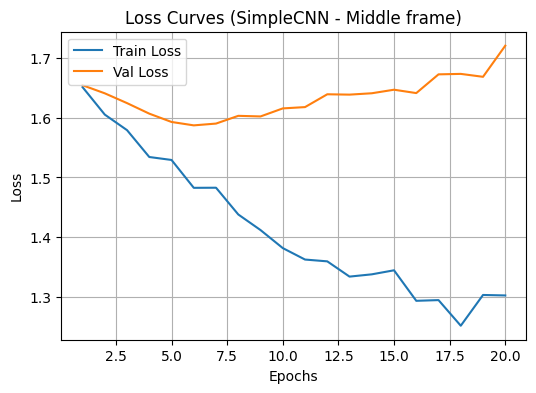

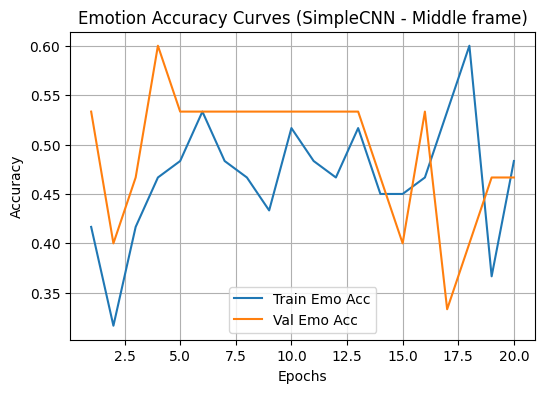

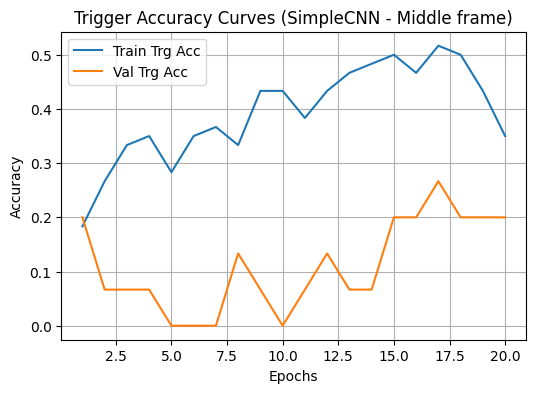

In [ ]:
train_df_mid, val_df_mid = train_test_split(
    df,
    test_size=VAL_SIZE,
    random_state=SEED,
    stratify=df["emo_idx"],
)

train_dataset_mid = EmotionTriggerVideoDataset(train_df_mid, transform=train_transform, random_frame=False)
val_dataset_mid   = EmotionTriggerVideoDataset(val_df_mid,   transform=val_transform,   random_frame=False)

train_loader_mid = DataLoader(train_dataset_mid, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=0, pin_memory=False)
val_loader_mid   = DataLoader(val_dataset_mid,   batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=0, pin_memory=False)

simple_cnn_mid = EmotionTriggerSimpleCNN(num_emo_classes, num_trg_classes).to(DEVICE)

run_name = "simplecnn_middle"
history_middle = train_model(
    simple_cnn_mid,
    train_loader_mid,
    val_loader_mid,
    DEVICE,
    EPOCHS,
    run_name=run_name,
    strategy="middle",
    model_name="SimpleCNN",
)

plot_history(history_middle, title_suffix="(SimpleCNN - Middle frame)")


Epoch 01/20 | train_loss=1.6849 val_loss=1.6602 | emo_acc: 0.267/0.333 | trg_acc: 0.150/0.200 | time=33.4s
Epoch 02/20 | train_loss=1.5978 val_loss=1.6549 | emo_acc: 0.433/0.467 | trg_acc: 0.233/0.133 | time=34.7s
Epoch 03/20 | train_loss=1.5539 val_loss=1.6424 | emo_acc: 0.417/0.533 | trg_acc: 0.267/0.067 | time=33.9s
Epoch 04/20 | train_loss=1.5308 val_loss=1.6202 | emo_acc: 0.450/0.533 | trg_acc: 0.367/0.067 | time=33.8s
Epoch 05/20 | train_loss=1.5250 val_loss=1.6043 | emo_acc: 0.367/0.533 | trg_acc: 0.317/0.067 | time=33.8s
Epoch 06/20 | train_loss=1.4553 val_loss=1.6131 | emo_acc: 0.483/0.533 | trg_acc: 0.417/0.133 | time=33.9s
Epoch 07/20 | train_loss=1.3809 val_loss=1.6194 | emo_acc: 0.500/0.533 | trg_acc: 0.533/0.067 | time=33.9s
Epoch 08/20 | train_loss=1.4439 val_loss=1.6136 | emo_acc: 0.483/0.533 | trg_acc: 0.433/0.133 | time=34.8s
Epoch 09/20 | train_loss=1.4622 val_loss=1.6255 | emo_acc: 0.350/0.533 | trg_acc: 0.317/0.133 | time=34.7s
Epoch 10/20 | train_loss=1.4490 val_l

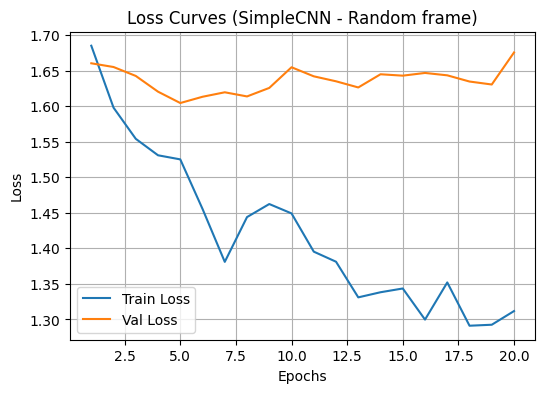

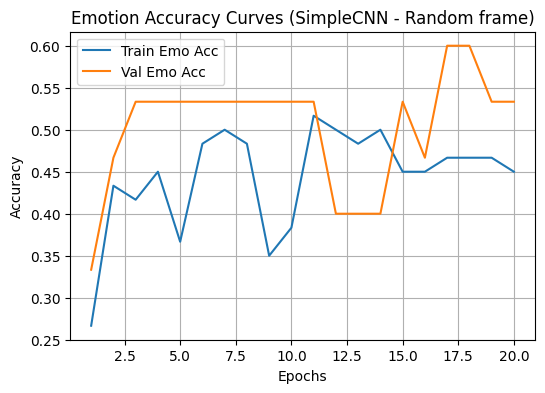

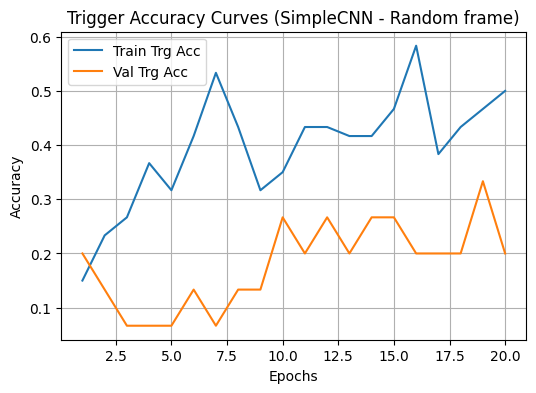

In [ ]:
train_df_rand, val_df_rand = train_test_split(
    df,
    test_size=VAL_SIZE,
    random_state=SEED,
    stratify=df["emo_idx"],
)

train_dataset_rand = EmotionTriggerVideoDataset(train_df_rand, transform=train_transform, random_frame=True)
val_dataset_rand   = EmotionTriggerVideoDataset(val_df_rand,   transform=val_transform,   random_frame=False)

train_loader_rand = DataLoader(train_dataset_rand, batch_size=BATCH_SIZE,
                               shuffle=True, num_workers=0, pin_memory=False)
val_loader_rand   = DataLoader(val_dataset_rand,   batch_size=BATCH_SIZE,
                               shuffle=False, num_workers=0, pin_memory=False)

simple_cnn_rand = EmotionTriggerSimpleCNN(num_emo_classes, num_trg_classes).to(DEVICE)

run_name = "simplecnn_random"
history_random = train_model(
    simple_cnn_rand,
    train_loader_rand,
    val_loader_rand,
    DEVICE,
    EPOCHS,
    run_name=run_name,
    strategy="random",
    model_name="SimpleCNN",
)

plot_history(history_random, title_suffix="(SimpleCNN - Random frame)")


In [ ]:
####

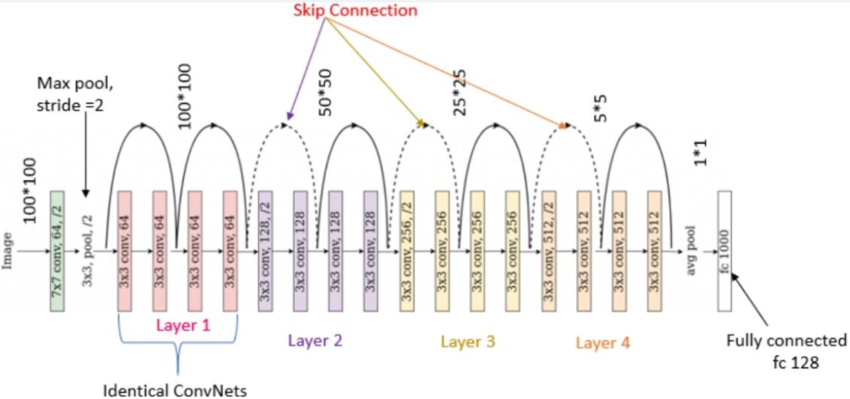

In [ ]:
from IPython.display import Image
Image(filename='Original-ResNet-18-Architecture.png')


In [ ]:
import torchvision.models as models

class EmotionTriggerResNet18(nn.Module):
    def __init__(self, num_emo_classes, num_trg_classes, freeze_backbone=False):
        super().__init__()

        backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        if freeze_backbone:
            for p in backbone.parameters():
                p.requires_grad = False

        in_features = backbone.fc.in_features
        backbone.fc = nn.Identity()
        self.backbone = backbone

        self.fc_shared = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
        )
        self.fc_emo = nn.Linear(256, num_emo_classes)
        self.fc_trg = nn.Linear(256, num_trg_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc_shared(x)
        emo_logits = self.fc_emo(x)
        trg_logits = self.fc_trg(x)
        return emo_logits, trg_logits


resnet_model = EmotionTriggerResNet18(
    num_emo_classes=num_emo_classes,
    num_trg_classes=num_trg_classes,
    freeze_backbone=True,
).to(DEVICE)

print(resnet_model)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 156MB/s]

EmotionTriggerResNet18(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

Epoch 01/20 | train_loss=1.6481 val_loss=1.5420 | emo_acc: 0.296/0.375 | trg_acc: 0.158/0.350 | time=163.4s
Epoch 02/20 | train_loss=1.5490 val_loss=1.4727 | emo_acc: 0.444/0.450 | trg_acc: 0.265/0.492 | time=152.6s
Epoch 03/20 | train_loss=1.4764 val_loss=1.4005 | emo_acc: 0.438/0.533 | trg_acc: 0.348/0.508 | time=154.3s
Epoch 04/20 | train_loss=1.3894 val_loss=1.3191 | emo_acc: 0.519/0.525 | trg_acc: 0.477/0.592 | time=155.7s
Epoch 05/20 | train_loss=1.2959 val_loss=1.2386 | emo_acc: 0.573/0.608 | trg_acc: 0.521/0.642 | time=155.7s
Epoch 06/20 | train_loss=1.2653 val_loss=1.1975 | emo_acc: 0.577/0.617 | trg_acc: 0.512/0.633 | time=152.6s
Epoch 07/20 | train_loss=1.2154 val_loss=1.1174 | emo_acc: 0.598/0.683 | trg_acc: 0.527/0.642 | time=153.3s
Epoch 08/20 | train_loss=1.1598 val_loss=1.0655 | emo_acc: 0.619/0.658 | trg_acc: 0.581/0.675 | time=152.6s
Epoch 09/20 | train_loss=1.0956 val_loss=1.0193 | emo_acc: 0.615/0.650 | trg_acc: 0.615/0.675 | time=150.6s
Epoch 10/20 | train_loss=1.0

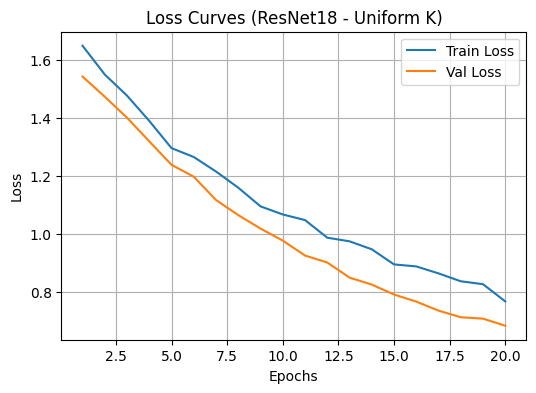

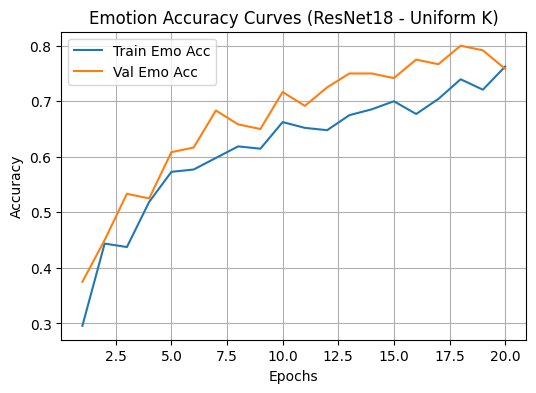

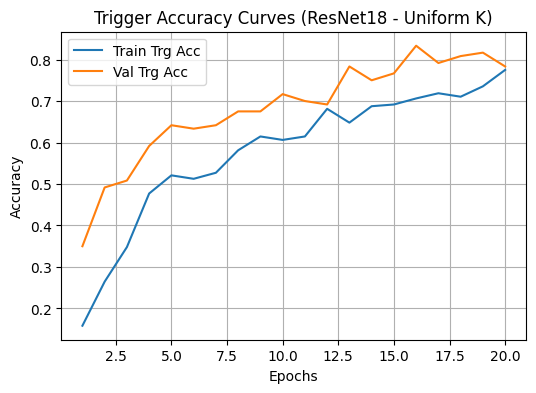

In [ ]:
run_name = "resnet18_uniformK"
history_resnet = train_model(
    resnet_model,
    train_loader_k,
    val_loader_k,
    DEVICE,
    EPOCHS,
    run_name=run_name,
    strategy=f"uniform_{K_FRAMES}",
    model_name="ResNet18",
)

plot_history(history_resnet, title_suffix="(ResNet18 - Uniform K)")


In [ ]:
##bonus part

In [ ]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from torch.nn.functional import relu

def eval_video_level_dataset(df_eval, model, max_frames=8):
    model.eval()
    emo_true, emo_pred = [], []
    trg_true, trg_pred = [], []

    with torch.no_grad():
        for _, row in df_eval.iterrows():
            video_path = row["video_path"]
            emo_label  = row["emo_idx"]
            trg_label  = row["trg_idx"]

            frames_tensor = []
            cap = cv2.VideoCapture(video_path)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            if total_frames <= 0:
                cap.release()
                continue

            frame_ids = np.linspace(0, total_frames - 1, max_frames, dtype=int)

            for fi in frame_ids:
                cap.set(cv2.CAP_PROP_POS_FRAMES, fi)
                ok, frame = cap.read()
                if ok and frame is not None:
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    img = Image.fromarray(frame)
                    img = val_transform(img)
                    frames_tensor.append(img)
            cap.release()

            if not frames_tensor:
                continue

            fr = torch.stack(frames_tensor).to(DEVICE)
            emo_logits, trg_logits = model(fr)

            emo_probs = torch.softmax(emo_logits, dim=1).mean(dim=0)
            trg_probs = torch.softmax(trg_logits, dim=1).mean(dim=0)

            emo_pred.append(emo_probs.argmax().item())
            trg_pred.append(trg_probs.argmax().item())
            emo_true.append(emo_label)
            trg_true.append(trg_label)

    return (
        np.array(emo_true),
        np.array(emo_pred),
        np.array(trg_true),
        np.array(trg_pred),
    )

def perturb_images(frames, mode="blur"):
    """
    frames: tensor of shape [T, C, H, W] in [0,1] (after val_transform)
    mode: "blur", "noise", "dark"
    """
    new_frames = []
    for img_tensor in frames:
        img = img_tensor.cpu().permute(1, 2, 0).numpy()
        img = (img * 255).astype(np.uint8)

        if mode == "blur":
            img = cv2.GaussianBlur(img, (7, 7), 0)
        elif mode == "noise":
            noise = np.random.normal(0, 10, img.shape).astype(np.int16)
            img = np.clip(img + noise, 0, 255).astype(np.uint8)
        elif mode == "dark":
            img = np.clip(img * 0.5, 0, 255).astype(np.uint8)

        img = Image.fromarray(img)
        new_frames.append(val_transform(img))
    return torch.stack(new_frames)

def eval_video_with_perturb(df_eval, model, mode=None, max_frames=8):
    model.eval()
    emo_true, emo_pred = [], []

    with torch.no_grad():
        for _, row in df_eval.iterrows():
            video_path = row["video_path"]
            emo_label  = row["emo_idx"]

            frames = []
            cap = cv2.VideoCapture(video_path)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            if total_frames <= 0:
                cap.release()
                continue

            frame_ids = np.linspace(0, total_frames - 1, max_frames, dtype=int)
            for fi in frame_ids:
                cap.set(cv2.CAP_PROP_POS_FRAMES, fi)
                ok, frame = cap.read()
                if ok and frame is not None:
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frames.append(val_transform(Image.fromarray(frame)))

            cap.release()
            if not frames:
                continue

            frames_tensor = torch.stack(frames)

            if mode is not None:
                frames_tensor = perturb_images(frames_tensor, mode)

            frames_tensor = frames_tensor.to(DEVICE)
            emo_logits, _ = model(frames_tensor)
            emo_probs = torch.softmax(emo_logits, dim=1).mean(dim=0)

            emo_true.append(emo_label)
            emo_pred.append(emo_probs.argmax().item())

    return np.array(emo_true), np.array(emo_pred)


Saved video-level validation results → val_video_results_resnet.csv


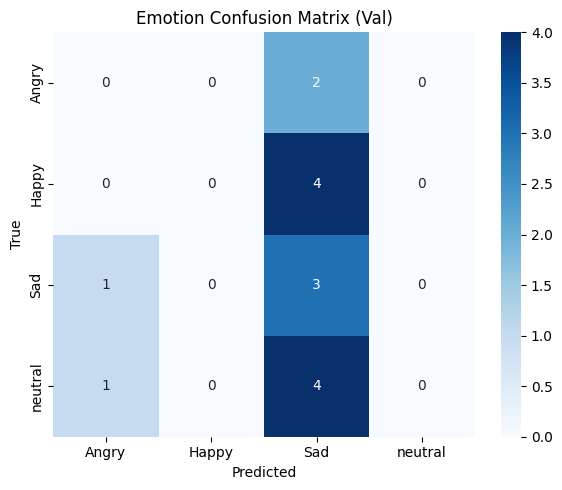

Saved confusion matrix → confusion_matrix_emotion_val.png
              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00         2
       Happy       0.00      0.00      0.00         4
         Sad       0.23      0.75      0.35         4
     neutral       0.00      0.00      0.00         5

    accuracy                           0.20        15
   macro avg       0.06      0.19      0.09        15
weighted avg       0.06      0.20      0.09        15

Saved classification report → classification_report_emotion_val.txt


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


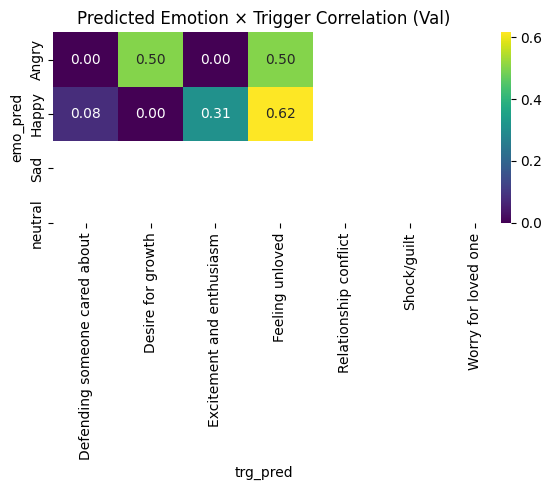

Saved correlation heatmap → emotion_trigger_correlation_val.png

Some misclassified samples (first 3):
YT_0fb0b651_new  | true: neutral | pred: Sad
H_YT_014  | true: Angry | pred: Sad
clip_015  | true: Happy | pred: Sad


In [ ]:

emo_true, emo_pred, trg_true, trg_pred = eval_video_level_dataset(
    val_df_mid,
    resnet_model,
    max_frames=8,
)

val_video_results = pd.DataFrame({
    "video_path": val_df_mid["video_path"].values[:len(emo_true)],
    "emo_true": emo_true,
    "emo_pred": emo_pred,
    "trg_true": trg_true,
    "trg_pred": trg_pred,
})
val_video_results.to_csv("val_video_results_resnet.csv", index=False)
print("Saved video-level validation results → val_video_results_resnet.csv")


cm = confusion_matrix(emo_true, emo_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True,
            xticklabels=emo_le.classes_,
            yticklabels=emo_le.classes_,
            fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Emotion Confusion Matrix (Val)")
plt.tight_layout()
plt.savefig("confusion_matrix_emotion_val.png")
plt.show()
print("Saved confusion matrix → confusion_matrix_emotion_val.png")

report_text = classification_report(emo_true, emo_pred, target_names=emo_le.classes_)
print(report_text)
with open("classification_report_emotion_val.txt", "w") as f:
    f.write(report_text)
print("Saved classification report → classification_report_emotion_val.txt")

df_temp = val_video_results.copy()
pivot = pd.crosstab(df_temp["emo_pred"], df_temp["trg_pred"], normalize="index")

plt.figure(figsize=(6, 5))
sns.heatmap(
    pivot, annot=True, fmt=".2f",
    xticklabels=trg_le.classes_,
    yticklabels=emo_le.classes_,
    cmap="viridis"
)
plt.title("Predicted Emotion × Trigger Correlation (Val)")
plt.tight_layout()
plt.savefig("emotion_trigger_correlation_val.png")
plt.show()
print("Saved correlation heatmap → emotion_trigger_correlation_val.png")


mismatch_idx = np.where(emo_true != emo_pred)[0][:3]
print("\nSome misclassified samples (first 3):")
for i in mismatch_idx:
    vid_id = val_df_mid.iloc[i]["ID"] if "ID" in val_df_mid.columns else f"idx_{i}"
    true_label = emo_le.inverse_transform([emo_true[i]])[0]
    pred_label = emo_le.inverse_transform([emo_pred[i]])[0]
    print(vid_id, " | true:", true_label, "| pred:", pred_label)


In [ ]:
robust_rows = []

for mode in [None, "blur", "noise", "dark"]:
    emo_t, emo_p = eval_video_with_perturb(
        val_df_mid,
        resnet_model,
        mode=mode,
        max_frames=8,
    )
    acc = (emo_t == emo_p).mean()
    mode_name = mode or "clean"
    robust_rows.append({"mode": mode_name, "accuracy": acc})
    print(f"{mode_name} accuracy = {acc:.3f}")

robust_df = pd.DataFrame(robust_rows)
robust_df.to_csv("robustness_results_resnet.csv", index=False)
print("Saved robustness results → robustness_results_resnet.csv")


clean accuracy = 0.200
blur accuracy = 0.200
noise accuracy = 0.200
dark accuracy = 0.200
Saved robustness results → robustness_results_resnet.csv


In [ ]:
print("Evaluating on RAVDESS external dataset...")

emo_true_ext, emo_pred_ext, trg_true_ext, trg_pred_ext = eval_video_level_dataset(
    df_ravdess,
    resnet_model,
    max_frames=8
)


ravdess_results = pd.DataFrame({
    "emo_true_ext": emo_true_ext,
    "emo_pred_ext": emo_pred_ext,
    "trg_true_ext": trg_true_ext,
    "trg_pred_ext": trg_pred_ext,
})

ravdess_results.to_csv("ravdess_eval_results.csv", index=False)
print("Saved RAVDESS evaluation results → ravdess_eval_results.csv")

from sklearn.metrics import classification_report
print("\n=== Emotion classification report on RAVDESS ===")
print(classification_report(emo_true_ext, emo_pred_ext))


Evaluating on RAVDESS external dataset...


NameError: name 'df_ravdess' is not defined

In [ ]:
!pip install kagglehub --quiet
import kagglehub
import os, cv2
from PIL import Image
import pandas as pd
import numpy as np
import torch


In [ ]:
path = kagglehub.dataset_download("msambare/fer2013")
print("Dataset downloaded to:", path)


100%|██████████| 60.3M/60.3M [00:00<00:00, 98.6MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [ ]:


print("Your emotion classes:", emo_le.classes_)

emo_name_to_idx = {name.upper(): idx for idx, name in enumerate(emo_le.classes_)}
print("Uppercase mapping:", emo_name_to_idx)


TARGET_EMOS = {"ANGRY", "HAPPY", "SAD", "NEUTRAL"}


Your emotion classes: ['Angry' 'Happy' 'Sad' 'neutral']
Uppercase mapping: {'ANGRY': 0, 'HAPPY': 1, 'SAD': 2, 'NEUTRAL': 3}


In [ ]:

import os
import glob
import pandas as pd

FER_ROOT = "/root/.cache/kagglehub/datasets/msambare/fer2013/versions/1"


FER_EMOS = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]

rows = []

for root, dirs, files in os.walk(FER_ROOT):

    folder_name = os.path.basename(root).lower()
    if folder_name not in FER_EMOS:
        continue


    emo_upper = folder_name.upper()


    if emo_upper not in TARGET_EMOS:

        continue

    if emo_upper not in emo_name_to_idx:
        print("Warning: emotion", emo_upper, "not found in your emo_le.classes_. Skipping.")
        continue

    emo_idx = emo_name_to_idx[emo_upper]


    for f in files:
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(root, f)
            rows.append({
                "video_path": img_path,
                "emo_idx": emo_idx,
                "trg_idx": 0,
            })

df_fer = pd.DataFrame(rows)
print("FER samples matched (only your 4 emotions):", len(df_fer))
display(df_fer.head())


FER samples matched (only your 4 emotions): 26217


,video_path,emo_idx,trg_idx
0,/root/.cache/kagglehub/datasets/msambare/fer20...,0,0
1,/root/.cache/kagglehub/datasets/msambare/fer20...,0,0
2,/root/.cache/kagglehub/datasets/msambare/fer20...,0,0
3,/root/.cache/kagglehub/datasets/msambare/fer20...,0,0
4,/root/.cache/kagglehub/datasets/msambare/fer20...,0,0


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('video_path').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['emo_idx']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'emo_idx'}, axis=1)
              .sort_values('emo_idx', ascending=True))
  xs = counted['emo_idx']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('emo_idx', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('video_path')):
  _plot_series(series, series_name, i)
  fig.legend(title='video_path', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('emo_idx')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['trg_idx']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'trg_idx'}, axis=1)
              .sort_values('trg_idx', ascending=True))
  xs = counted['trg_idx']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('trg_idx', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('video_path')):
  _plot_series(series, series_name, i)
  fig.legend(title='video_path', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('trg_idx')
_ = plt.ylabel('count()')

In [ ]:
def eval_video_level_dataset(df_eval, model, max_frames=8):
    model.eval()
    emo_true, emo_pred = [], []
    trg_true, trg_pred = [], []

    with torch.no_grad():
        for _, row in df_eval.iterrows():
            video_path = row["video_path"]
            emo_label  = row["emo_idx"]
            trg_label  = row["trg_idx"]

            frames_tensor = []

            if video_path.lower().endswith((".png", ".jpg", ".jpeg")):
                try:
                    img = Image.open(video_path).convert("RGB")
                except:
                    continue
                img = val_transform(img)
                frames_tensor.append(img)
            else:

                cap = cv2.VideoCapture(video_path)
                total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                if total_frames <= 0:
                    cap.release()
                    continue

                frame_ids = np.linspace(0, total_frames - 1, max_frames, dtype=int)
                for fi in frame_ids:
                    cap.set(cv2.CAP_PROP_POS_FRAMES, fi)
                    ok, frame = cap.read()
                    if ok and frame is not None:
                        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        img = Image.fromarray(frame)
                        img = val_transform(img)
                        frames_tensor.append(img)
                cap.release()

            if not frames_tensor:
                continue

            fr = torch.stack(frames_tensor).to(DEVICE)
            emo_logits, trg_logits = model(fr)

            emo_probs = torch.softmax(emo_logits, dim=1).mean(dim=0)
            trg_probs = torch.softmax(trg_logits, dim=1).mean(dim=0)

            emo_pred.append(emo_probs.argmax().item())
            trg_pred.append(trg_probs.argmax().item())
            emo_true.append(emo_label)
            trg_true.append(trg_label)

    return (
        np.array(emo_true),
        np.array(emo_pred),
        np.array(trg_true),
        np.array(trg_pred),
    )


Saved FER evaluation results → fer2013_eval_results_resnet.csv

=== Emotion Classification Report on FER2013 (External, 4 emotions) ===
              precision    recall  f1-score   support

       Angry       0.19      0.16      0.18      4953
       Happy       0.00      0.00      0.00      8989
         Sad       0.23      0.82      0.35      6077
     neutral       1.00      0.00      0.00      6198

    accuracy                           0.22     26217
   macro avg       0.36      0.25      0.13     26217
weighted avg       0.33      0.22      0.12     26217

Saved → fer2013_classification_report_emotion.txt


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


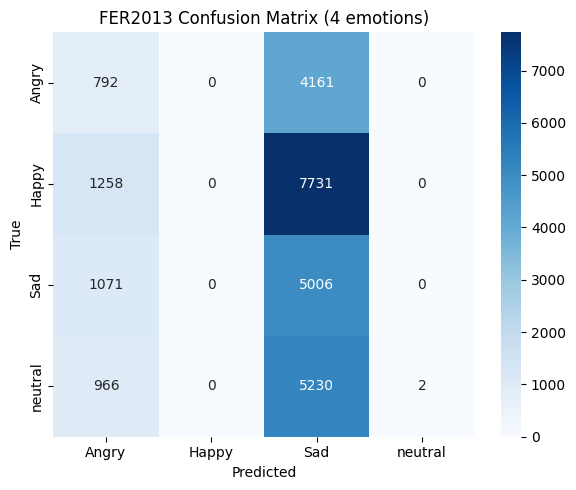

Saved → fer2013_confusion_matrix_4emos.png


In [ ]:

emo_true_fer, emo_pred_fer, trg_true_fer, trg_pred_fer = eval_video_level_dataset(
    df_fer,
    resnet_model,
    max_frames=1,
)

fer_results = pd.DataFrame({
    "video_path": df_fer["video_path"].values[:len(emo_true_fer)],
    "emo_true_fer": emo_true_fer,
    "emo_pred_fer": emo_pred_fer,
})
fer_results.to_csv("fer2013_eval_results_resnet.csv", index=False)
print("Saved FER evaluation results → fer2013_eval_results_resnet.csv")


from sklearn.metrics import classification_report, confusion_matrix
print("\n=== Emotion Classification Report on FER2013 (External, 4 emotions) ===")
fer_report = classification_report(
    emo_true_fer,
    emo_pred_fer,
    target_names=[c for c in emo_le.classes_ if c.upper() in TARGET_EMOS],
)
print(fer_report)

with open("fer2013_classification_report_emotion.txt", "w") as f:
    f.write(fer_report)
print("Saved → fer2013_classification_report_emotion.txt")


cm_fer = confusion_matrix(emo_true_fer, emo_pred_fer)
plt.figure(figsize=(6, 5))

label_names_4 = [c for c in emo_le.classes_ if c.upper() in TARGET_EMOS]
sns.heatmap(
    cm_fer, annot=True, fmt="d",
    xticklabels=label_names_4,
    yticklabels=label_names_4,
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("FER2013 Confusion Matrix (4 emotions)")
plt.tight_layout()
plt.savefig("fer2013_confusion_matrix_4emos.png")
plt.show()
print("Saved → fer2013_confusion_matrix_4emos.png")


Saved timeline → timeline_YT_0fb0b651_new.png


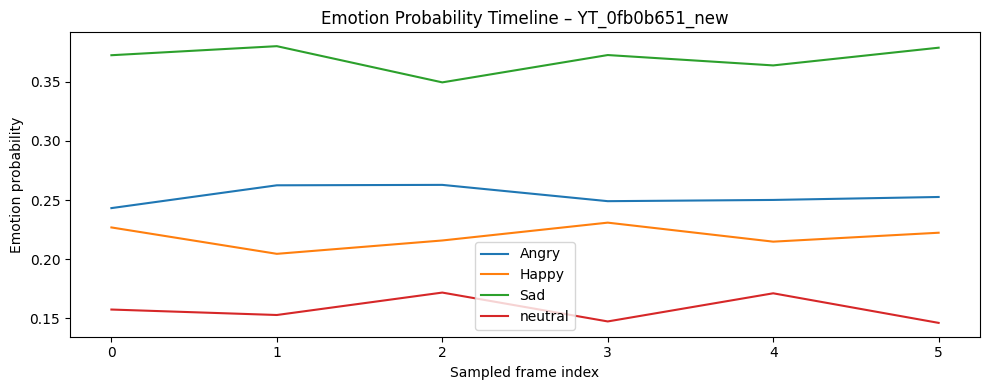

In [ ]:

def plot_timeline(video_path, model, video_id, max_frames=6, save=True):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames <= 0:
        cap.release()
        print("No frames in video:", video_path)
        return

    frame_ids = np.linspace(0, total_frames - 1, max_frames, dtype=int)
    frames = []

    for fi in frame_ids:
        cap.set(cv2.CAP_PROP_POS_FRAMES, fi)
        ok, frame = cap.read()
        if ok and frame is not None:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(val_transform(Image.fromarray(frame)))

    cap.release()
    if not frames:
        print("Could not read frames for:", video_path)
        return

    frames_tensor = torch.stack(frames).to(DEVICE)
    emo_logits, _ = model(frames_tensor)
    probs = torch.softmax(emo_logits, dim=1).detach().cpu().numpy()


    plt.figure(figsize=(10, 4))
    for c in range(num_emo_classes):
        plt.plot(probs[:, c], label=emo_le.classes_[c])
    plt.xlabel("Sampled frame index")
    plt.ylabel("Emotion probability")
    plt.title(f"Emotion Probability Timeline – {video_id}")
    plt.legend()
    plt.tight_layout()
    if save:
        fname = f"timeline_{video_id}.png"
        plt.savefig(fname)
        print("Saved timeline →", fname)
    plt.show()


video_id = row.get("ID", "idx0")
plot_timeline(video_path, resnet_model, video_id=video_id, max_frames=6)


In [ ]:
###uncompleted

In [ ]:

from sklearn.model_selection import train_test_split

fer_train_df, fer_val_df = train_test_split(
    df_fer,
    test_size=0.2,
    random_state=SEED,
    stratify=df_fer["emo_idx"],
)

print("FER train samples:", len(fer_train_df))
print("FER val samples  :", len(fer_val_df))
fer_train_df.head()


FER train samples: 20973
FER val samples  : 5244


,video_path,emo_idx,trg_idx
8168,/root/.cache/kagglehub/datasets/msambare/fer20...,1,0
13277,/root/.cache/kagglehub/datasets/msambare/fer20...,3,0
4197,/root/.cache/kagglehub/datasets/msambare/fer20...,1,0
16647,/root/.cache/kagglehub/datasets/msambare/fer20...,2,0
20011,/root/.cache/kagglehub/datasets/msambare/fer20...,2,0


In [ ]:

class FERImageDataset(Dataset):

    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["video_path"]
        emo_label = int(row["emo_idx"])

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, emo_label


fer_train_ds = FERImageDataset(fer_train_df, transform=train_transform)
fer_val_ds   = FERImageDataset(fer_val_df,   transform=val_transform)

fer_train_loader = DataLoader(
    fer_train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=False,
)

fer_val_loader = DataLoader(
    fer_val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
)

print("FER train batches:", len(fer_train_loader))
print("FER val batches  :", len(fer_val_loader))


FER train batches: 2622
FER val batches  : 656


In [ ]:

class FerBaselineCNN(nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(

            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 112x112


            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 56x56


            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 28x28


            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 14x14
        )
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x

fer_baseline = FerBaselineCNN(num_emo_classes).to(DEVICE)
print(fer_baseline)


FerBaselineCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum

In [ ]:

def accuracy_from_logits_1head(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

def train_one_epoch_fer(model, loader, optimizer, device, criterion):
    model.train()
    running_loss = 0.0
    running_acc  = 0.0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        bs = images.size(0)
        running_loss += loss.item() * bs
        running_acc  += accuracy_from_logits_1head(logits, labels) * bs
        total += bs

    return running_loss / total, running_acc / total

def evaluate_fer(model, loader, device, criterion):
    model.eval()
    running_loss = 0.0
    running_acc  = 0.0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            loss = criterion(logits, labels)

            bs = images.size(0)
            running_loss += loss.item() * bs
            running_acc  += accuracy_from_logits_1head(logits, labels) * bs
            total += bs

    return running_loss / total, running_acc / total

def train_fer_model(model, train_loader, val_loader, device, epochs, run_name="fer_baseline"):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
    }

    best_val_loss = float("inf")
    best_state = None

    for ep in range(1, epochs + 1):
        t0 = time.time()
        tr_loss, tr_acc = train_one_epoch_fer(model, train_loader, optimizer, device, criterion)
        val_loss, val_acc = evaluate_fer(model, val_loader, device, criterion)
        dt = time.time() - t0

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()

        print(
            f"Epoch {ep:02d}/{epochs} | "
            f"train_loss={tr_loss:.4f} val_loss={val_loss:.4f} | "
            f"train_acc={tr_acc:.3f} val_acc={val_acc:.3f} | "
            f"time={dt:.1f}s"
        )

    if best_state is not None:
        model_path = f"{run_name}_best.pt"
        torch.save(best_state, model_path)
        print(f"Best FER baseline model saved to {model_path} (val_loss={best_val_loss:.4f})")


    record = {
        "run_name": run_name,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "model_name": "FerBaselineCNN",
        "strategy": "FER-2013 4-class",
        "epochs": len(history["train_loss"]),
        "final_train_loss": history["train_loss"][-1],
        "final_val_loss": history["val_loss"][-1],
        "final_train_emo_acc": history["train_acc"][-1],
        "final_val_emo_acc": history["val_acc"][-1],
        "final_train_trg_acc": None,
        "final_val_trg_acc": None,
        "best_val_loss": best_val_loss,
        "best_val_emo_acc": max(history["val_acc"]),
        "best_val_trg_acc": None,
    }

    if os.path.exists(RUN_LOG):
        log_df = pd.read_csv(RUN_LOG)
        log_df = pd.concat([log_df, pd.DataFrame([record])], ignore_index=True)
    else:
        log_df = pd.DataFrame([record])
    log_df.to_csv(RUN_LOG, index=False)
    print(f"FER baseline run logged to {RUN_LOG}")

    return history

EPOCHS_FER = 10

fer_history = train_fer_model(
    fer_baseline,
    fer_train_loader,
    fer_val_loader,
    DEVICE,
    epochs=EPOCHS_FER,
    run_name="fer_baseline_cnn",
)


KeyboardInterrupt: 

In [ ]:

def plot_fer_history(history, title_suffix="FER Baseline CNN"):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss Curves – {title_suffix}")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy Curves – {title_suffix}")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_fer_history(fer_history)
